**_워드 임베딩?_**    
-> 텍스트를 컴퓨터가 이해할 수 있도록 수치화하는 하나의 방법   
-> 각 단어를 인공 신경망 학습을 통해 벡터화함

-----

# 1. 워드 임베딩
- 단어를 벡터로 표현하는 방법.
- 단어를 밀집 표현으로 변환

## 1.1 희소 표현(Sparse Representation) 
벡터 또는 행렬의 값이 대부분 0으로 표현되는 방법.   
ex) 원-핫 인코딩을 통해 나온 원-핫 벡터는 표현하고자 하는 단어의 인덱스만 1이고 나머지 인덱스는 전부 0으로 표현   
ex) DTM : 특정 문서에 다수 등장한 단어가 다른 많은 문서에서는 등장하지 않으면 행렬의 많은 값이 0이 된다.   
- 문제점   
    1) 단어 개수가 늘어나면 벡터의 차원이 한없이 커진다. -> 공간낭비   
    2) 단어의 의미를 표현하지 못한다.   
    3) 단어 벡터 간 유의미한 유사도를 계산할 수 없다. 
    
## 1.2 밀집 표현(Dense Representation)
사용자가 설정한 값으로 모든 단어의 벡터 표현의 차원을 맞추며, 벡터값은 0과 1만이 아니라 실수값을 갖는다.

## 1.3 워드 임베딩(Word Embedding)
단어를 밀집 벡터(dense vector)의 형태로 표현하는 방법.   
이 밀집 벡터를 워드 임베딩 과정을 통해 나온 결과라고 하여 임베딩 벡터라고도 한다.
<img src="./09-1.png">

# 2. 워드투벡터(word2Vec)
단어 벡터 간 유의미한 유사도를 파악할 수 있도록 단어의 의미를 수치화하는 대표적인 방법

### 분산 표현
희소 표현 방법의 대안으로, 단어의 의미를 다차원 공간에 벡터화하는 표현 방법.   
분포 가설을 이용하여 **텍스트를 학습**하고, 단어의 의미를 벡터의 여러 차원에 분산하여 표현.
- 분포 가설 : 비슷한 문맥에서 등장하는 단어들은 비슷한 의미를 가진다.   

분산 표현을 이용하여 단어 간 의미적 유사성을 벡터화하는 작업을 **워드 임베딩**이라 부르며, 이렇게 표현된 벡터를 **임베딩 벡터**라 한다.   

#### Word2Vec의 학습 방식에는 CBOW(Continuous Bag of Words)와 Skip-Gram 두 가지 방식이 있다.

## 1) CBOW(Continuous Bag of Words)
주변에 있는 단어들을 입력으로 중간에 있는 단어들을 예측하는 방법    
- 윈도우 : 중심 단어를 예측하기 위해서 앞, 뒤로 몇 개의 단어를 볼지에 대한 범위   
- 윈도우 크기가 n이라면, 실제 중심 단어를 예측하기 위해 참고하려고 하는 주변 단어의 개수는 2n개이다.   

투사층에서 입력 벡터인 2n개의 벡터의 평균을 구한다.
  
## 2) Skip-gram
중간에 있는 단어들을 입력으로 주변 단어들을 예측하는 방법   
중심 단어에 대해서 주변 단어를 예측하므로 투사층에서 벡터들의 평균을 구하는 과정이 없다.

**_1), 2)에 대한 추가설명은 꼭 교재 참고!!(그림이 많고 책에 나온 내용을 이해하는 게 중요해서 따로 요약X)_**
- CBOW, Skip-gram 설명 : https://wikidocs.net/22660
    
## NNLM  VS Word2Vec

<img src="./09-2.png">

### NNLM
- 단어 벡터 간 유사도를 구할 수 있도록 워드 임베딩 개념 도입
- 다음 단어를 예측하는 언어 모델 구현이 목적 -> 다음 단어를 예측
- 예측 단어의 이전 단어들만을 참고
- 활성화 함수가 있는 은닉층 존재

### Word2VEC
- 워드 임베딩 자체에 집중. NNLM의 느린 학습 속도와 정확도 개선
- 워드 임베딩 자체가 목적. -> 중심 단어를 예측
- 예측 단어의 전, 후 단어들을 모두 참고
- 활성화 함수가 있는 은닉층 제거 -> 학습 속도에 강점.

# 3. 영어/한국어 Word2Vec 실습
gensim 패키지에서 제공하는 이미 구현된 Word2Vec을 사용

## 3.1 영어 Word2Vec 만들기

### 3.1.2 훈련 데이터 전처리

In [1]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

In [29]:
# 훈련 데이터 다운로드 - xml문서형식
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial\
/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x254a71008b0>)

> 현재 경로로 데이터가 다운로드된다.   
\<content>, \</content> 사이의 내용들은 전처리하고, Laughter나 Applause와 같은 배경음을 나타내는 단어도 제거해야 한다.

In [3]:
# 훈련 데이터 전처리 코드
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)
target_text

In [4]:
# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

> **xpath문법 참고**
> - https://velog.io/@mjhuh263/TIL-23-HTML-XPATH-%EB%AC%B8%EB%B2%95%EA%B3%BC-selenium%EC%97%90-XPATH-%EC%9D%B4%EC%9A%A9%ED%95%98%EA%B8%B0

In [5]:
# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

> **re.sub 참고**
> - https://clolee.tistory.com/17

> **정규표현식 참고**
> - https://wikidocs.net/4308
> - https://uipath.tistory.com/91

In [6]:
# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [7]:
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


In [8]:
# 샘플 3개만 출력 - 토큰화 수행되었음을 확인 가능
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


### 3.1.2 Word2Vec 모델

In [9]:
#!pip install gensim

In [10]:
# Word2Vec 훈련시키기
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

> Word2Vec의 하이퍼파라미터
> - vector_size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
> - window = 컨텍스트 윈도우 크기
> - min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습X)
> - workers = 학습을 위한 프로세스 수
> - sg = 0은 CBOW, 1은 Skip-gram.

> **오류해결** : __init__() got an unexpected keyword argument 'size'
> - https://taepseon.tistory.com/165

In [11]:
# model.wv.most_similar : 입력한 단어에 대해서 가장 유사한 단어들을 출력
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.8552982211112976), ('guy', 0.8003278970718384), ('lady', 0.7555043697357178), ('boy', 0.7506000995635986), ('girl', 0.7420408129692078), ('gentleman', 0.7367627024650574), ('soldier', 0.706470251083374), ('kid', 0.6824928522109985), ('poet', 0.6788013577461243), ('surgeon', 0.6699748635292053)]


In [12]:
# Word2Vec 모델 저장하고 로드하기
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [13]:
model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.8552982211112976), ('guy', 0.8003278970718384), ('lady', 0.7555043697357178), ('boy', 0.7506000995635986), ('girl', 0.7420408129692078), ('gentleman', 0.7367627024650574), ('soldier', 0.706470251083374), ('kid', 0.6824928522109985), ('poet', 0.6788013577461243), ('surgeon', 0.6699748635292053)]


## 3.2 한국어 Word2Vec 만들기(네이버 영화 리뷰)

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [15]:
# 네이버 영화 리뷰 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master\
/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x254a7073a00>)

In [16]:
train_data = pd.read_table('ratings.txt')
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [17]:
print(len(train_data)) # 리뷰 개수 출력

200000


In [18]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


In [19]:
# 결측값 제거
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인
print(len(train_data)) # 리뷰 개수 출력

False
199992


In [20]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5] # 상위 5개 출력

C:\Users\hkny0\AppData\Local\Temp\ipykernel_23200\3523926270.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


> str.replace의 argument에 관한 future warning   
> - The default value of regex will change from True to False in a future version.
> - https://stackoverflow.com/questions/66603854/futurewarning-the-default-value-of-regex-will-change-from-true-to-false-in-a-fu

In [21]:
## 불용어 제거
from tqdm import tqdm

# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████| 199992/199992 [10:53<00:00, 306.24it/s]


> **<tqdm 사용법>**
> - 반복문에서 진행률을 progress bar로 표혀해주고 남은 시간 정보까지 알려주는 모듈
> - https://zephyrus1111.tistory.com/305

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


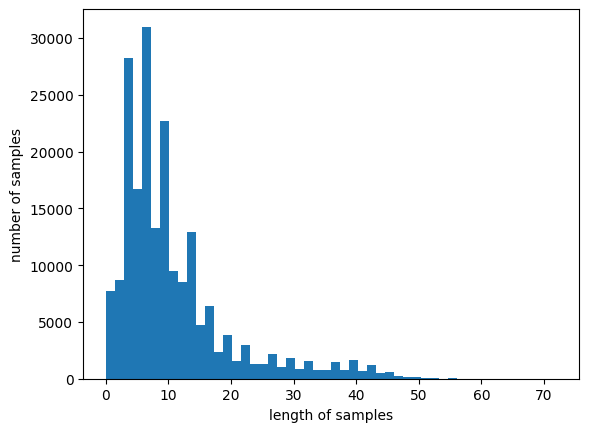

In [22]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [3]:
# Word2Vec으로 토큰화 된 네이버 영화 리뷰 데이터를 학습
from gensim.models import Word2Vec

model2 = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

NameError: name 'tokenized_data' is not defined

In [24]:
# 완성된 임베딩 매트릭스의 크기 확인
model2.wv.vectors.shape

(16477, 100)

In [25]:
# '최민식'과 유사한 단어 출력
print(model2.wv.most_similar("최민식"))

[('안성기', 0.8796866536140442), ('한석규', 0.8416503071784973), ('송강호', 0.8336511254310608), ('엄정화', 0.827076256275177), ('양동근', 0.8270566463470459), ('설경구', 0.8223000764846802), ('다우니', 0.8217430114746094), ('유다인', 0.8207724690437317), ('채민서', 0.818321704864502), ('이정재', 0.8107035160064697)]


## 3.3 사전 훈련된 Word2Vec 임베딩(Pre-trained Word2Vec embedding) 소개
갖고 있는 훈련 데이터의 양이 부족한 상황이라면, 위키피디아 등의 방대한 데이터로 사전에 훈련된 워드 임베딩(pre-trained word embedding vector)을 가지고 와서 해당 벡터들의 값을 원하는 작업에 사용 할 수도 있다.

구글이 제공하는 사전 훈련된 Word2Vec 모델을 사용하는 방법에 대해 알아보자.   
- 모델 다운로드 경로 : https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit   


In [33]:
import gensim
import urllib.request

# 구글의 사전 훈련된 Word2Vec 모델을 로드 - 이걸로 안돼서 직접 다운받고 로드함.
#urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
#                           filename="GoogleNews-vectors-negative300.bin.gz")

# 구글의 사전 훈련된 Word2Vec 모델을 로드.
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [34]:
# 모델의 크기 확인
print(word2vec_model.vectors.shape)

(3000000, 300)


In [35]:
# 두 단어의 유사도 계산 연습
print(word2vec_model.similarity('this', 'is'))
print(word2vec_model.similarity('post', 'book'))

0.40797037
0.057204384


In [36]:
# 단어 'book'의 벡터 출력
print(word2vec_model['book'][:20])

[ 0.11279297 -0.02612305 -0.04492188  0.06982422  0.140625    0.03039551
 -0.04370117  0.24511719  0.08740234 -0.05053711  0.23144531 -0.07470703
  0.21875     0.03466797 -0.14550781  0.05761719  0.00671387 -0.00701904
  0.13183594 -0.25390625]


# 4. 네거티브 샘플링을 이용한 Word2Vec 구현(Skip-Gram with Negative Sampling, SGNS)

## 4.1 네거티브 샘플링(Negative Sampling)
보통의 Word2Vec는 단어 집합의 크기가 수만 이상에 달한다면 학습하기 꽤나 무거운 모델이 된다. **네거티브 샘플링**은 Word2Vec이 학습 과정에서 전체 단어 집합이 아니라 일부 단어 집합에만 집중할 수 있도록 하는 방법. 기존의 단어 집합을 이진 분류 문제를 위한 데이터셋으로 변환한다.

## 4.2 네거티브 샘플링 Skip-Gram(Skip-Gram with Negative Sampling, SGNS)

앞서 배운 Skip-gram은 중심 단어를 입력에 사용하여, 주변 단어를 예측하는 모델이다.   
반면 네거티브 샘플링을 사용하는 Skip-gram(이하 SGNS)는 중심 단어와 주변 단어가 모두 입력이 되고, 이 두 단어가 실제로 윈도우 크기 내에 존재하는 이웃 관계인지에 대한 확률을 예측하는 모델이다.

**_추가설명은 꼭 교재 참고!!_**
- https://wikidocs.net/69141

## 4.3 20뉴스그룹 데이터 전처리하기
중심 단어, 주변 단어의 관계가 성립하기 위해 데이터는 하나의 샘플에 최소 단어 2개가 있어야 한다. 따라서 전처리 과정에서 지속적으로 이를 만족하지 않는 샘플들을 제거한다.

In [43]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups    # 20뉴스그룹 데이터 사용
from tensorflow.keras.preprocessing.text import Tokenizer

In [44]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


In [45]:
documents[0]

"Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n"

In [46]:
### 전처리 진행
# list -> dataframe
news_df = pd.DataFrame({'document':documents})  #document라는 열이름 사용
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

C:\Users\hkny0\AppData\Local\Temp\ipykernel_23200\2716589182.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")


In [47]:
# 결측값 유무 확인
news_df.isnull().values.any()

False

In [48]:
# empty값 유무 확인 (empty값->null값변환->결측값유무 다시확인)
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [49]:
# 결측값 제거
news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 10995


In [50]:
# 불용어 제거
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [51]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)  # 행 삭제
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


C:\ProgramData\Anaconda3\envs\data\lib\site-packages\numpy\lib\function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


> **동일 배열 차원의 각 차원의 요소 길이가 다른 경우**
> - https://homzzang.com/b/py-311
> - https://statools.tistory.com/322

In [52]:
# 단어 집합 생성 후 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}  # dict comprehension
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [53]:
print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [54]:
# 단어 집합 크기 확인
vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


## 4.4 네거티브 샘플링을 통한 데이터셋 구성하기
skipgrams 사용 : 네거티브 샘플링을 위해 케라스에서 제공하는 전처리 도구   
상위 10개의 뉴스그룹 샘플에 대해서만 수행해보자.

In [55]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링 - 상위 10개 샘플만
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [56]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(whole (217), existance (4865)) -> 1
(sure (59), bayne (32675)) -> 0
(power (68), starlight (50728)) -> 0
(ruin (9470), aplcenmp (41337)) -> 0
(received (634), inhuman (10668)) -> 1


In [57]:
print('전체 샘플 수 :',len(skip_grams))  # 상위10게

전체 샘플 수 : 10


In [58]:
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2220
2220


> 10개의 뉴스그룹 샘플 각각은 수많은 중심 단어, 주변 단어의 쌍으로 된 샘플들을 갖고 있다.

## 4.5 Skip-Gram with Negative Sampling(SGNS) 구현하기

In [59]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [60]:
# 임베딩 벡터의 차원 : 100
embedding_dim = 100

## 임베딩 층 두 개 추가

# 1) 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 2) 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embedding_dim)(c_inputs)

각 단어는 임베딩 테이블을 거쳐서 내적을 수행하고, 내적의 결과는 1 또는 0을 예측하기 위해서 시그모이드 함수를 활성화 함수로 거쳐 최종 예측값을 얻는다.

In [61]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

# 모델 생성
model_SGNS = Model(inputs=[w_inputs, c_inputs], outputs=output)
model_SGNS.summary()
model_SGNS.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model_SGNS, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       6427700     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       6427700     ['input_2[0][0]']                
                                                                                              

In [62]:
# 모델 학습 : 5 epoch
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model_SGNS.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 1 Loss : 6.931409537792206
Epoch : 2 Loss : 6.907058894634247
Epoch : 3 Loss : 6.881697237491608
Epoch : 4 Loss : 6.851515471935272
Epoch : 5 Loss : 6.814041197299957


## 4.6 결과 확인하기

In [ ]:
import gensim

# 학습된 임베딩 벡터들을 저장
f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model_SGNS.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

# 모델 로드
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

> **Question2.**
> - name 'embed_size' is not defined...
> - embed_size 아니고 embedding_dim인 것 같은데 확실하지가 않다...ㅠㅠ

> 마지막 6. 결과 확인하기 부분의 코드 중 
f.write('{} {}\n'.format(vocab_size-1, embed_size)) 라는 코드에서 
embed_size라는 변수가 앞에서 지정되어 있지 않아서 오류남.
이 embed_size가 혹시 앞에서 지정한 임베딩 벡터의 차원인 embedding_dim을 잘 못 쓴 건가...?

In [ ]:
w2v.most_similar(positive=['soldiers'])

In [ ]:
w2v.most_similar(positive=['doctor'])

In [ ]:
w2v.most_similar(positive=['police'])

# 5. 글로브(GloVe)
* LSA : 카운트 기반
    - 장) 코퍼스의 전체적인 통계 정보 고려
    - 단) 단어 의미의 유추 작업에 불리
* Word2Vec : 예측 기반
    - 장) 단어 간 유추 작업에 유리
    - 단) 코퍼스의 전체적인 통계 정보 반영 X


* **글로브** : 카운트 기반(ex. LSA)과 예측 기반(ex. Word2Vec)을 모두 사용하는 방법론   
    - Word2Vec만큼 뛰어난 성능을 보여주므로, 실제로 두 가지 모두 사용해보고 성능이 더 좋은 것을 사용하는 게 바람직하다.


## 윈도우 기반 동시 등장 행렬, 동시 등장 확률, 손실 함수
GloVe의 목표는 **임베딩 된 중심 단어와 주변 단어 벡터의 내적이 전체 코퍼스에서의 동시 등장 확률이 되도록 임베딩 벡터를 만드는 것**이다!!

**추가설명은 꼭꼭꼭 교재 참고!!**
- https://wikidocs.net/22885

## 5.2 GloVe 훈련시키기

In [ ]:
!pip install glove-python-binary

> **Question3.**   
설치가 안돼여... 실습 못해여...ㅠㅅㅠ

In [ ]:
from glove import Corpus, Glove

corpus = Corpus() 

# 훈련 데이터로부터 GloVe에서 사용할 동시 등장 행렬 생성
corpus.fit(result, window=5)
glove = Glove(no_components=100, learning_rate=0.05)

# 학습하기 : 학습에 이용할 쓰레드의 개수는 4로 설정, 에포크는 20.
glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)

In [ ]:
print(glove.most_similar("man"))

In [ ]:
print(glove.most_similar("boy"))

In [ ]:
print(glove.most_similar("university"))

# 6. 패스트텍스트(FastText)
Word2Vec를 확장한 메커니즘이지만, Word2Vec는 단어를 쪼개질 수 없는 단위로 생각한다면, FastText는 하나의 단어 안에도 여러 단어들이 존재하는 것으로 간주한다는 차이가 있다.   
다시 말해, FastText는 내부 단어, 즉 서브워드(subword)를 고려하여 학습한다.

## 6.1 내부 단어(subword)의 학습
FastText에서는 각 단어를 글자 단위 n-gram의 구성으로 취급한다.   
ex) n=3. 즉, 트라이그램(tri-gram)이고, 단어는 apple이라면   
내부 단어 토큰은 \<apple>에서 <ap, app, ppl, ple, le>로 5개이고, 여기에 기본적으로 <apple>을 추가해 총 6개의 토큰을 벡터화한다.

## 6.2 모르는 단어(Out Of Vocabulary, OOV)에 대한 대응
FastText의 인공 신경망을 학습한 후에는 데이터 셋의 모든 단어의 각 n-gram에 대해서 워드 임베딩이 된다. 이것의 장점은 **내부 단어(Subword)를 통해 모르는 단어(Out Of Vocabulary, OOV)에 대해서도 다른 단어와의 유사도를 계산할 수 있다는 점**이다.

## 6.3 단어 집합 내 빈도 수가 적었던 단어(Rare Word)에 대한 대응
등장 빈도 수가 적은 단어(rare word)에 대해서는 임베딩의 정확도가 높지 않은 Word2Vec와 달리, FastText의 경우, 만약 단어가 희귀 단어라도, **그 단어의 n-gram이 다른 단어의 n-gram과 겹치는 경우**라면, Word2Vec과 비교하여 비교적 높은 임베딩 벡터값을 얻는다. 또한 같은 이유로, 노이즈(오타)가 많은 코퍼스에서 강점을 갖는다.

## 6.4 실습으로 비교하는 Word2Vec Vs. FastText

In [38]:
# 1) Word2Vec - 3.1의 model변수 사용 -> 오류남
#model.wv.most_similar("electrofishing")

KeyError: "Key 'electrofishing' not present in vocabulary"

> 오류남. 즉 Word2Vec는 모르는 단어에 대해서는 임베딩 벡터가 존재하지 않으므로 단어의 유사도를 계산할 수 없다.

In [40]:
# 2) FastText
from gensim.models import FastText

model_FT = FastText(result, vector_size=100, window=5, min_count=5, workers=4, sg=1)

model_FT.wv.most_similar("electrofishing")   # 유사한 단어를 계산해서 출력함

[('electrolux', 0.8758091926574707),
 ('electrolyte', 0.8690634965896606),
 ('electroshock', 0.8613851070404053),
 ('electro', 0.8550385236740112),
 ('electroencephalogram', 0.8453898429870605),
 ('electrochemical', 0.8423638939857483),
 ('airbus', 0.8329404592514038),
 ('electric', 0.826469361782074),
 ('electronic', 0.824472188949585),
 ('electrogram', 0.8241185545921326)]

> 'size' argument로 오류나서 size -> vector_size로 변경

## 6.5 한국어에서의 FastText
OOV 문제를 해결하기 위한 시도

### 1) 음절 단위
음절 단위의 임베딩의 경우에 n=3일때 ‘자연어처리’라는 단어에 대해 n-gram을 만들어보면 다음과 같다.
* **<자연, 자연어, 연어처, 어처리, 처리>**

### 2) 자모 단위(초성, 중성, 종성 단위)
오타나 노이즈 측면에서 더 강한 임베딩을 기대해볼 수 있다.   
‘자연어처리’라는 단어에 대해서 초성, 중성, 종성을 분리하고, 만약, 종성이 존재하지 않는다면 ‘\_’라는 토큰을 사용한다고 가정한다면 ‘자연어처리’라는 단어는 아래와 같이 분리가 가능하며, 분리된 결과의 대한 tri-gram 적용 결과는 다음과 같다.
* 분리된 결과 : ㅈ ㅏ _ ㅇ ㅕ ㄴ ㅇ ㅓ _ ㅊ ㅓ _ ㄹ ㅣ _
* < ㅈ ㅏ, ㅈ ㅏ \_, ㅏ _ ㅇ, ... 중략>

# 7. 자모 단위 한국어 FastText 학습하기
-> 웹사이트에서 비공개 처리됨.

# 8. 사전 훈련된 워드 임베딩(Pre-trained Word Embedding)
케라스 임베딩 층과 비교해보자!!

## 8.1 케라스 임베딩 층(Keras Embedding layer)
- 훈련 데이터의 단어들에 대해 워드 임베딩을 수행하는 도구 Embedding()을 제공
- 현재 갖고 있는 훈련 데이터의 단어들을 임베딩 층(embedding layer)을 구현하여 임베딩 벡터로 학습

### 1) 임베딩 층 = 룩업 테이블
케라스는 단어를 정수 인덱스로 바꾸고 원-핫 벡터로 변환 후 임베딩 층의 입력으로 사용하는 것이 아니라, **단어를 정수 인코딩까지만 진행 후 임베딩 층의 입력으로 사용하여 룩업 테이블 결과인 임베딩 벡터를 리턴**한다.   
ex) 특정 단어 'great' -> 정수 인코딩 -> 룩업 테이블에서 해당 정수를 인덱스로 갖는 임베딩 벡터를 가져옴. -> 이 임베딩 벡터는 모델의 입력이 되고, 역전파 과정에서 단어 'great;의 임베딩 벡터값이 학습됨.

In [63]:
# 케라스 임베딩 층 구현하기
vocab_size = 20000   # 텍스트 데이터의 전체 단어 집합의 크기
output_dim = 128     # 워드 임베딩 후의 임베딩 벡터의 차원
input_length = 500   # 입력 시퀀스의 길이 (갖고 있는 각 샘플의 길이...)

v = Embedding(vocab_size, output_dim, input_length=input_length)

> **Embedding() 작동 과정**
> 1) (number of samples, input_length)인 2D 정수 텐서를 입력받음.   
    - 이때 각 sample은 정수 시퀀스(= 정수 인코딩의 결과)   
> 2) 워드 임베딩 작업을 수행   
> 3) (number of samples, input_length, embedding word dimentionality)인 3D 실수 텐서를 리턴

### 2) 임베딩 층 사용하기
문장의 긍, 부정을 판단하는 감성 분류 모델을 만들어보자. 긍정문은 label 1, 부정문은 label 0

In [64]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentences = ['nice great best amazing', 'stop lies', 'pitiful nerd', 'excellent work', 'supreme quality', 'bad', 'highly respectable']
y_train = [1, 0, 0, 1, 1, 0, 1]

In [65]:
# 전처리 : 1) 단어집합 생성 후 크기 확인
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_index) + 1 # 패딩을 고려하여 +1
print('단어 집합 :',vocab_size)

단어 집합 : 16


In [66]:
# 전처리 : 2) 각 문장에 대한 정수 인코딩 수행
X_encoded = tokenizer.texts_to_sequences(sentences)
print('정수 인코딩 결과 :',X_encoded)

정수 인코딩 결과 : [[1, 2, 3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13], [14, 15]]


In [67]:
# 가장 길이가 긴 문장의 길이 확인
max_len = max(len(l) for l in X_encoded)
print('최대 길이 :',max_len)

최대 길이 : 4


In [68]:
# 전처리 : 3) 최대 길이로 모든 샘플에 대한 패딩 진행
X_train = pad_sequences(X_encoded, maxlen=max_len, padding='post')
y_train = np.array(y_train)
print('패딩 결과 :')
print(X_train)

패딩 결과 :
[[ 1  2  3  4]
 [ 5  6  0  0]
 [ 7  8  0  0]
 [ 9 10  0  0]
 [11 12  0  0]
 [13  0  0  0]
 [14 15  0  0]]


In [69]:
## 이진 분류 모델 생성 : 손실함수는 binary_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

embedding_dim = 4

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=100, verbose=2)

Epoch 1/100
1/1 - 0s - loss: 0.6953 - acc: 0.4286 - 378ms/epoch - 378ms/step
Epoch 2/100
1/1 - 0s - loss: 0.6942 - acc: 0.4286 - 3ms/epoch - 3ms/step
Epoch 3/100
1/1 - 0s - loss: 0.6931 - acc: 0.4286 - 4ms/epoch - 4ms/step
Epoch 4/100
1/1 - 0s - loss: 0.6920 - acc: 0.4286 - 5ms/epoch - 5ms/step
Epoch 5/100
1/1 - 0s - loss: 0.6908 - acc: 0.4286 - 3ms/epoch - 3ms/step
Epoch 6/100
1/1 - 0s - loss: 0.6897 - acc: 0.7143 - 5ms/epoch - 5ms/step
Epoch 7/100
1/1 - 0s - loss: 0.6886 - acc: 0.7143 - 3ms/epoch - 3ms/step
Epoch 8/100
1/1 - 0s - loss: 0.6875 - acc: 0.8571 - 2ms/epoch - 2ms/step
Epoch 9/100
1/1 - 0s - loss: 0.6864 - acc: 0.8571 - 4ms/epoch - 4ms/step
Epoch 10/100
1/1 - 0s - loss: 0.6853 - acc: 0.8571 - 4ms/epoch - 4ms/step
Epoch 11/100
1/1 - 0s - loss: 0.6842 - acc: 0.8571 - 3ms/epoch - 3ms/step
Epoch 12/100
1/1 - 0s - loss: 0.6830 - acc: 0.8571 - 2ms/epoch - 2ms/step
Epoch 13/100
1/1 - 0s - loss: 0.6819 - acc: 0.8571 - 2ms/epoch - 2ms/step
Epoch 14/100
1/1 - 0s - loss: 0.6808 - acc:

## 8.2 사전 훈련된 워드 임베딩(Pre-Trained Word Embedding) 사용하기
- 훈련 데이터가 적은 상황이라면 케라스의 Embedding()으로 해당 문제를 풀기에 최적화 된 임베딩 벡터값을 얻는 것이 쉽지 않다. 
- 이 경우 해당 문제에 특화된 것은 아니지만 보다 많은 훈련 데이터를 가지고 Word2Vec이나 GloVe 등을 통해 미리 훈련(학습)되어 있는 임베딩 벡터들을 사용할 수도 있다.

### 1) 사전 훈련된 GloVe 사용하기
-> glove 설치도 안되는데 무슨...ㅠ   
-> 책만 한번 읽어봄

### 2) 사전 훈련된 Word2Vec 사용하기
- 모델 다운로드 경로 : 3.3 참고

In [70]:
import gensim

# 구글의 사전 훈련된 Word2Vec 모델 로드 - 안되므로 실제로 다운받아야 함.
#urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
#                           filename="GoogleNews-vectors-negative300.bin.gz")

# word2vec_model에 저장
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', 
                                                                 binary=True)

print('모델의 크기(shape) :',word2vec_model.vectors.shape) # 모델의 크기 확인

모델의 크기(shape) : (3000000, 300)


In [79]:
embedding_matrix = np.zeros((vocab_size, 300))
print('임베딩 행렬의 크기(shape) :',np.shape(embedding_matrix))

임베딩 행렬의 크기(shape) : (16, 300)


> **오류해결**
> - SyntaxError: unexpected EOF while parsing
> - 뒤에 괄호 하나 빠짐.
> - https://janeljs.github.io/python/unexpected-eof/

In [81]:
# word2vec_model에 특정 단어의 임베딩 벡터가 없다면 None을 리턴하는 함수 생성
def get_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

In [82]:
for word, index in tokenizer.word_index.items():
    # 단어와 맵핑되는 사전 훈련된 임베딩 벡터값
    vector_value = get_vector(word)
    if vector_value is not None:
        embedding_matrix[index] = vector_value

In [83]:
# 단어 'nice'의 임베딩 벡터값 확인
print(word2vec_model['nice'])

[ 0.15820312  0.10595703 -0.18945312  0.38671875  0.08349609 -0.26757812
  0.08349609  0.11328125 -0.10400391  0.17871094 -0.12353516 -0.22265625
 -0.01806641 -0.25390625  0.13183594  0.0859375   0.16113281  0.11083984
 -0.11083984 -0.0859375   0.0267334   0.34570312  0.15136719 -0.00415039
  0.10498047  0.04907227 -0.06982422  0.08642578  0.03198242 -0.02844238
 -0.15722656  0.11865234  0.36132812  0.00173187  0.05297852 -0.234375
  0.11767578  0.08642578 -0.01123047  0.25976562  0.28515625 -0.11669922
  0.38476562  0.07275391  0.01147461  0.03466797  0.18164062 -0.03955078
  0.04199219  0.01013184 -0.06054688  0.09765625  0.06689453  0.14648438
 -0.12011719  0.08447266 -0.06152344  0.06347656  0.3046875  -0.35546875
 -0.2890625   0.19628906 -0.33203125 -0.07128906  0.12792969  0.09619141
 -0.12158203 -0.08691406 -0.12890625  0.27734375  0.265625    0.1796875
  0.12695312  0.06298828 -0.34375    -0.05908203  0.0456543   0.171875
  0.08935547  0.14648438 -0.04638672 -0.00842285 -0.0279

In [84]:
# 단어 'nice'의 맵핑된 정수 확인
print('단어 nice의 맵핑된 정수 :', tokenizer.word_index['nice'])

단어 nice의 맵핑된 정수 : 1


In [85]:
# embedding_matirx의 1번 인덱스 확인 - 모델의 임베딩 벡터값과 동일!
print(embedding_matrix[1])

[ 0.15820312  0.10595703 -0.18945312  0.38671875  0.08349609 -0.26757812
  0.08349609  0.11328125 -0.10400391  0.17871094 -0.12353516 -0.22265625
 -0.01806641 -0.25390625  0.13183594  0.0859375   0.16113281  0.11083984
 -0.11083984 -0.0859375   0.0267334   0.34570312  0.15136719 -0.00415039
  0.10498047  0.04907227 -0.06982422  0.08642578  0.03198242 -0.02844238
 -0.15722656  0.11865234  0.36132812  0.00173187  0.05297852 -0.234375
  0.11767578  0.08642578 -0.01123047  0.25976562  0.28515625 -0.11669922
  0.38476562  0.07275391  0.01147461  0.03466797  0.18164062 -0.03955078
  0.04199219  0.01013184 -0.06054688  0.09765625  0.06689453  0.14648438
 -0.12011719  0.08447266 -0.06152344  0.06347656  0.3046875  -0.35546875
 -0.2890625   0.19628906 -0.33203125 -0.07128906  0.12792969  0.09619141
 -0.12158203 -0.08691406 -0.12890625  0.27734375  0.265625    0.1796875
  0.12695312  0.06298828 -0.34375    -0.05908203  0.0456543   0.171875
  0.08935547  0.14648438 -0.04638672 -0.00842285 -0.0279

In [86]:
# 모델 학습 : Embedding에 사전 훈련된 embedding_matrix를 입력으로 넣어준다.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input

model = Sequential()
model.add(Input(shape=(max_len,), dtype='int32'))
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=100, verbose=2)

Epoch 1/100
1/1 - 0s - loss: 0.6949 - acc: 0.5714 - 460ms/epoch - 460ms/step
Epoch 2/100
1/1 - 0s - loss: 0.6758 - acc: 0.5714 - 2ms/epoch - 2ms/step
Epoch 3/100
1/1 - 0s - loss: 0.6572 - acc: 0.8571 - 2ms/epoch - 2ms/step
Epoch 4/100
1/1 - 0s - loss: 0.6393 - acc: 0.8571 - 3ms/epoch - 3ms/step
Epoch 5/100
1/1 - 0s - loss: 0.6219 - acc: 0.8571 - 3ms/epoch - 3ms/step
Epoch 6/100
1/1 - 0s - loss: 0.6051 - acc: 1.0000 - 3ms/epoch - 3ms/step
Epoch 7/100
1/1 - 0s - loss: 0.5888 - acc: 1.0000 - 6ms/epoch - 6ms/step
Epoch 8/100
1/1 - 0s - loss: 0.5731 - acc: 1.0000 - 3ms/epoch - 3ms/step
Epoch 9/100
1/1 - 0s - loss: 0.5579 - acc: 1.0000 - 5ms/epoch - 5ms/step
Epoch 10/100
1/1 - 0s - loss: 0.5433 - acc: 1.0000 - 4ms/epoch - 4ms/step
Epoch 11/100
1/1 - 0s - loss: 0.5292 - acc: 1.0000 - 5ms/epoch - 5ms/step
Epoch 12/100
1/1 - 0s - loss: 0.5156 - acc: 1.0000 - 4ms/epoch - 4ms/step
Epoch 13/100
1/1 - 0s - loss: 0.5025 - acc: 1.0000 - 4ms/epoch - 4ms/step
Epoch 14/100
1/1 - 0s - loss: 0.4899 - acc:

---------
사전 훈련된 워드 임베딩을 이용한 텍스트 분류는 **'NLP를 이용한 합성곱 신경망'** 챕터의 **의도 분류 실습**( https://wikidocs.net/86083 )을 참고하세요~

# 9. 엘모(ELMo : Embeddings from Language Model)
사전 훈련된 언어 모델(Pre-trained language model)을 사용하는 임베딩!!
- 텐서플로우 2.0에서는 TF-Hub의 ELMo를 사용할 수 없으므로, 텐서플로우 버전을 1버전으로 낮춘 후 사용해야 한다.

## 9.1 ELMo
같은 표기의 단어라도 문맥에 따라서 다르게 사용되는 단어에 대해, Word2Vec이나 GloVe 등으로 표현된 임베딩 벡터들은 이를 제대로 반영하지 못한다는 단점이 있다.   
ex) Bank Account(은행 계좌) / River Bank(강둑)

**문맥을 반영한 워드 임베딩(Contextualized Word Embedding)**을 할 수 있다면 자연어 처리의 성능을 올릴 수 있을 것이다!!

## 9.2 biLM(Bidirectional Language Model)의 사전 훈련
1) ELMo는 순방향 RNN 뿐만 아니라, 반대 방향으로 문장을 스캔하는 역방향 RNN 또한 활용한다. ELMo는 양쪽 방향의 언어 모델을 둘 다 학습하여 활용한다고 하여 이 언어 모델을 biLM(Bidirectional Language Model) 이라고 한다.

2) biLM은 기본적으로 다층 구조(Multi-layer)를 전제로 하며, 은닉층이 최소 2개 이상이다. biLM의 각 시점의 입력이 되는 단어 벡터는 이번 챕터에서 설명한 임베딩 층(embedding layer)을 사용해서 얻은 것이 아니라 합성곱 신경망을 이용한 문자 임베딩(character embedding)을 통해 얻은 단어 벡터이다.
* 문자 임베딩에 대해서는 **'NLP를 위한 합성곱 신경망'** 챕터에서 다룸.

3) 양방향 RNN과의 차이점
- 양방향 RNN : 순방향 RNN의 은닉 상태와 역방향의 RNN의 은닉 상태를 연결(concatenate)하여 다음층의 입력으로 사용
- biLM : 순방향 언어모델과 역방향 언어모델이라는 두 개의 언어 모델을 별개의 모델로 보고 학습

## 9.3 biLM의 활용
ELMo가 임베딩 벡터를 얻는 과정   
1) 각 층의 출력값을 연결(concatenate)한다.   
2) 각 층의 출력값 별로 가중치를 준다.   
3) 가중합(Weighted Sum)을 한다.   
4) 벡터의 크기를 결정하는 스칼라 매개변수를 곱한다.   
-> 이렇게 완성된 벡터를 ELMo 표현(representation)이라고 한다.

**ELMo 표현을 기존의 임베딩 벡터와 함께 사용**하는 등의 방법으로 자연어 처리 작업을 수행할 수 있다.

**_추가설명은 꼭 교재 참고!!_**
- https://wikidocs.net/69141

## 9.4 ELMo 표현을 사용해서 스팸 메일 분류하기

In [93]:
# 텐서플로우 버전 확인
import tensorflow as tf
print(tf.__version__)  # 원래 2.9.3이다!!! 나중에 다시 되돌려야 하므로 알아두기

2.9.3


> **텐서플로우 버전 확인 및 업/다운그레이드**
> - https://jimmy-ai.tistory.com/107
> - https://patiencelee.tistory.com/674
> - https://dk-kang.tistory.com/entry/%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EC%9A%B0-%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EC%9A%B0-1-%EB%B2%84%EC%A0%84-%EC%82%AC%EC%9A%A9%ED%95%98%EA%B8%B0-in-%EA%B5%AC%EA%B8%80-%EC%BD%94%EB%9E%A9

> 다운그레이드가 안돼서... 이후 실습도 실패ㅜㅜㅜ

In [97]:
#!pip install tensorflow-hub

     -------------------------------------- 108.8/108.8 kB 6.6 MB/s eta 0:00:00


> 텐서플로우 허브로부터 다양한 사전 훈련된 모델(Pre-tained Model)들을 사용할 수 있다.

> **오류!!**   
> Ignoring invalid distribution -ensorflow

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from keras import backend as K
import urllib.request
import pandas as pd
import numpy as np

In [ ]:
elmo = hub.Module("https://tfhub.dev/google/elmo/1", trainable=True)
# 텐서플로우 허브로부터 ELMo를 다운로드

sess = tf.Session()
K.set_session(sess)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [ ]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin-1')
data[:5]

In [ ]:
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])  # v1열 값을 숫자 레이블로 변환
y_data = list(data['v1'])
X_data = list(data['v2'])

In [ ]:
X_data[:5]

In [ ]:
print(y_data[:5])

In [ ]:
# train, test 데이터 분할
print(len(X_data))
n_of_train = int(len(X_data) * 0.8)
n_of_test = int(len(X_data) - n_of_train)
print(n_of_train)
print(n_of_test)

In [ ]:
X_train = np.asarray(X_data[:n_of_train]) #X_data 데이터 중에서 앞의 4457개의 데이터만 저장
y_train = np.asarray(y_data[:n_of_train]) #y_data 데이터 중에서 앞의 4457개의 데이터만 저장
X_test = np.asarray(X_data[n_of_train:]) #X_data 데이터 중에서 뒤의 1115개의 데이터만 저장
y_test = np.asarray(y_data[n_of_train:]) #y_data 데이터 중에서 뒤의 1115개의 데이터만 저장

In [ ]:
# 데이터의 이동이 케라스 → 텐서플로우 → 케라스가 되도록 하는 함수
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), as_dict=True, signature="default")["default"]

In [ ]:
# 모델 설계
from keras.models import Model
from keras.layers import Dense, Lambda, Input

input_text = Input(shape=(1,), dtype=tf.string)
embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
hidden_layer = Dense(256, activation='relu')(embedding_layer)
output_layer = Dense(1, activation='sigmoid')(hidden_layer)
model = Model(inputs=[input_text], outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 모델 학습
history = model.fit(X_train, y_train, epochs=1, batch_size=60)

In [ ]:
# 테스트 데이터 정확도 평가
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

# 10. 임베딩 벡터의 시각화(Embedding Visualization)
구글은 임베딩 프로젝터(embedding projector)라는 데이터 시각화 도구를 지원한다.

## 10.1 워드 임베딩 모델로부터 2개의 tsv 파일 생성하기
시각화를 위해서는 이미 모델을 학습하고, 파일로 저장되어져 있어야 한다.   
모델이 저장되어져 있다면 아래 커맨드를 통해 시각화에 필요한 파일들을 생성할 수 있다.

In [2]:
!python -m gensim.scripts.word2vec2tensor --input eng_w2v --output eng_w2v

2023-01-16 19:38:01,214 - word2vec2tensor - INFO - running C:\ProgramData\Anaconda3\envs\data\lib\site-packages\gensim\scripts\word2vec2tensor.py --input eng_w2v --output eng_w2v
2023-01-16 19:38:01,215 - keyedvectors - INFO - loading projection weights from eng_w2v
2023-01-16 19:38:02,490 - utils - INFO - KeyedVectors lifecycle event {'msg': 'loaded (21613, 100) matrix of type float32 from eng_w2v', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-01-16T19:38:02.470125', 'gensim': '4.3.0', 'python': '3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'load_word2vec_format'}
2023-01-16 19:38:03,753 - word2vec2tensor - INFO - 2D tensor file saved to eng_w2v_tensor.tsv
2023-01-16 19:38:03,754 - word2vec2tensor - INFO - Tensor metadata file saved to eng_w2v_metadata.tsv
2023-01-16 19:38:03,754 - word2vec2tensor - INFO - finished running word2vec2tensor.py


> 커맨드를 수행하면 주피터 노트북이 시작되는 경로에 기존에 있던 eng_w2v를 포함해 총 세 개의 파일이 생긴다. 
> - eng_w2v
> - eng_w2v_metadata.tsv
> - eng_w2v_tensor.tsw

> 코드와 파일이름의 'eng_w2v' 부분에는 내가 지정한 모델이름이 들어간다.   
> 새로 생긴 eng_w2v_metadata.tsv와 eng_w2v_tensor.tsv 이 두 개 파일이 임베딩 벡터 시각화를 위해 사용할 파일이다!

## 10.2 임베딩 프로젝터를 사용하여 시각화하기
구글의 임베딩 프로젝터를 사용해서 워드 임베딩 모델을 시각화해보자.
- 링크 : https://projector.tensorflow.org/

# 11. 문서 벡터를 이용한 추천 시스템(Recommendation System using Document Embedding)
문서들을 고정된 길이의 벡터로 변환한다면 벡터 간 비교로 문서들을 서로 비교할 수 있다.   
각 문서를 문서 벡터로 변환하는 방법은 이미 구현된 패키지인 Doc2Vec이나 Sent2Vec 등을 사용하여 학습하는 방법도 존재하지만, 단어 벡터를 얻은 뒤 문서에 존재하는 단어 벡터들의 평균을 문서 벡터로 간주할 수도 있다. 

문서 내 각 단어들을 Word2Vec을 통해 단어 벡터로 변환하고, 이들의 평균으로 문서 벡터를 얻어 선호하는 도서와 유사한 도서를 찾아주는 도서 추천 시스템을 만들어보자.

## 11.1 데이터 로드
- 실습에 사용할 데이터 : 책의 이미지와 책의 줄거리를 크롤링한 데이터
- 데이터 다운로드 링크 : https://drive.google.com/file/d/15Q7DZ7xrJsI2Hji-WbkU9j1mwnODBd5A/view?usp=sharing

In [7]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/data.csv", filename="data.csv")
df = pd.read_csv("data.csv")
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 2382


In [9]:
# 상위 5개 행 출력 -> Desc열에 주목
df[:5]

,Unnamed: 0.1,Desc,Unnamed: 0,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


In [10]:
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

# Desc열을 전처리한 후 'cleaned'열에 저장
df['cleaned'] = df['Desc'].apply(_removeNonAscii)
df['cleaned'] = df.cleaned.apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(remove_stop_words)
df['cleaned'] = df.cleaned.apply(remove_punctuation)
df['cleaned'] = df.cleaned.apply(remove_html)

In [11]:
# 상위 5개만 출력
df['cleaned'][:5]

0    know power shifting west east north south pres...
1    following success accidental billionaires mone...
2    tap power social software networks build busin...
3    william j bernstein american financial theoris...
4    amazing book joined steve jobs many akio morit...
Name: cleaned, dtype: object

In [12]:
# 전처리 과정에서 생긴 빈 행 제거
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('전체 문서의 수 :',len(df))   # 2382 -> 2381 (-1)

전체 문서의 수 : 2381


In [13]:
# 토큰화 수행
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

## 11.2 사전 훈련된 워드 임베딩 사용하기
Word2Vec을 처음부터 학습할 수도 있겠지만, 데이터가 충분하지 않은 상황에서 사전 훈련된 워드 임베딩을 단어 벡터의 초기값으로 사용하여 성능을 높일 수도 있다.

In [14]:
import gensim
from gensim.models import Word2Vec

In [15]:
#urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
#                           filename="GoogleNews-vectors-negative300.bin.gz")

word2vec_model = Word2Vec(size = 300, window=5, min_count = 2, workers = -1)
word2vec_model.build_vocab(corpus)

# 사전 훈련된 Word2Vec을 로드 후 초기 단어 벡터값으로 사용
word2vec_model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)
word2vec_model.train(corpus, total_examples = word2vec_model.corpus_count, epochs = 15)

C:\ProgramData\Anaconda3\envs\data\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


(0, 0)

> **오류해결**   
> 'Word2Vec' object has no attribute 'intersect_word2vec_format'
> - pip uninstall gensim -> pip install gensim==3.6.0 를 하거나...(난 요걸로~) 
> - https://myohyun.tistory.com/286 요기처럼 해결하거나

> **gensim 버전 차이점**
> - 교재는 3버전으로 작성됨.
> - but 현재 install gensim을 하면 4버전으로 설치됨.
> - 4버전은 Word2Vec내 argument가 size -> vector_size로 변경됨
> - 4버전은 intersect_word2vec_format가 wv안으로 들어감.

> **warining**   
> 근데 계속 같은 warining이 떠서 신경쓰인다...ㅠㅠ    
> WARNING: Ignoring invalid distribution -ensorflow (c:\programdata\anaconda3\envs\data\lib\site-packages)

## 11.3 단어 벡터의 평균 구하기

In [16]:
def get_document_vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [17]:
document_embedding_list = get_document_vectors(df['cleaned'])
print('문서 벡터의 수 :',len(document_embedding_list))

C:\Users\hkny0\AppData\Local\Temp\ipykernel_12556\913432021.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = word2vec_model[word]
C:\Users\hkny0\AppData\Local\Temp\ipykernel_12556\913432021.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = doc2vec + word2vec_model[word]


문서 벡터의 수 : 2381


## 11.4 추천 시스템 구현하기

In [18]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (2381, 2381)


In [19]:
def recommendations(title):
    books = df[['title', 'image_link']]

    # 책의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()    
    idx = indices[title]

    # 입력된 책과 줄거리(document embedding)가 유사한 책 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 책 5권의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    fig = plt.figure(figsize=(20, 30))

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.title(row['title'])

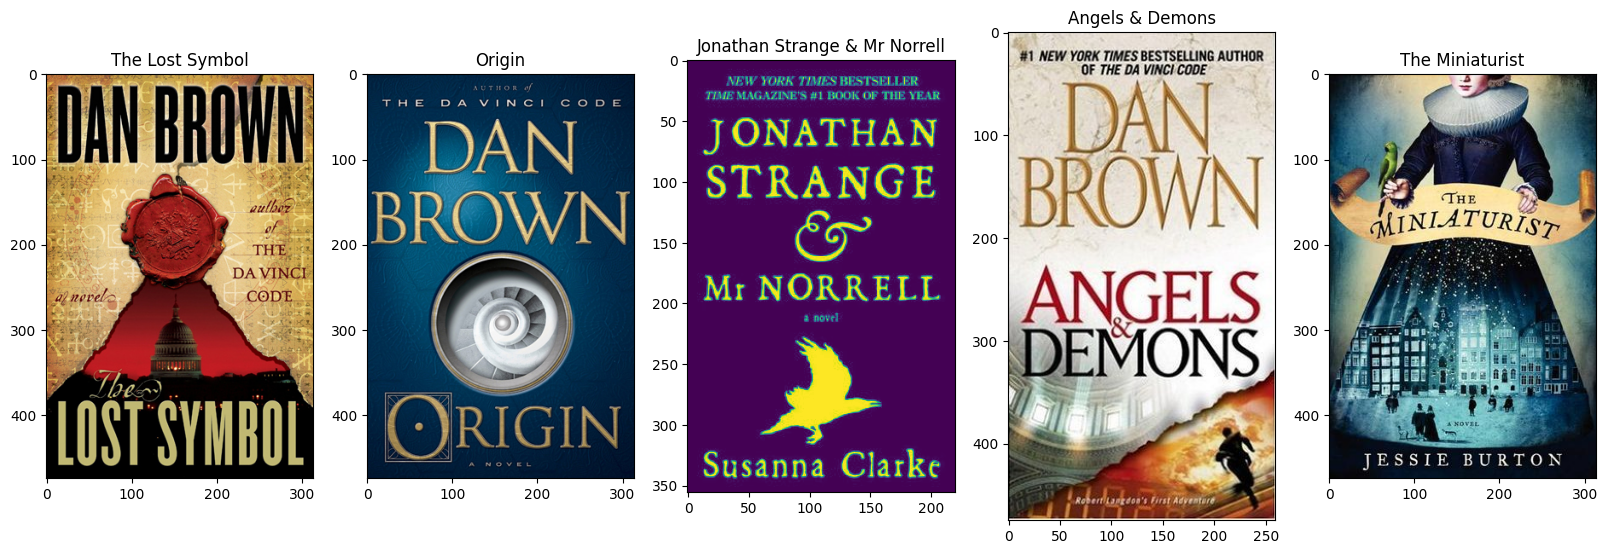

In [20]:
recommendations("The Da Vinci Code")

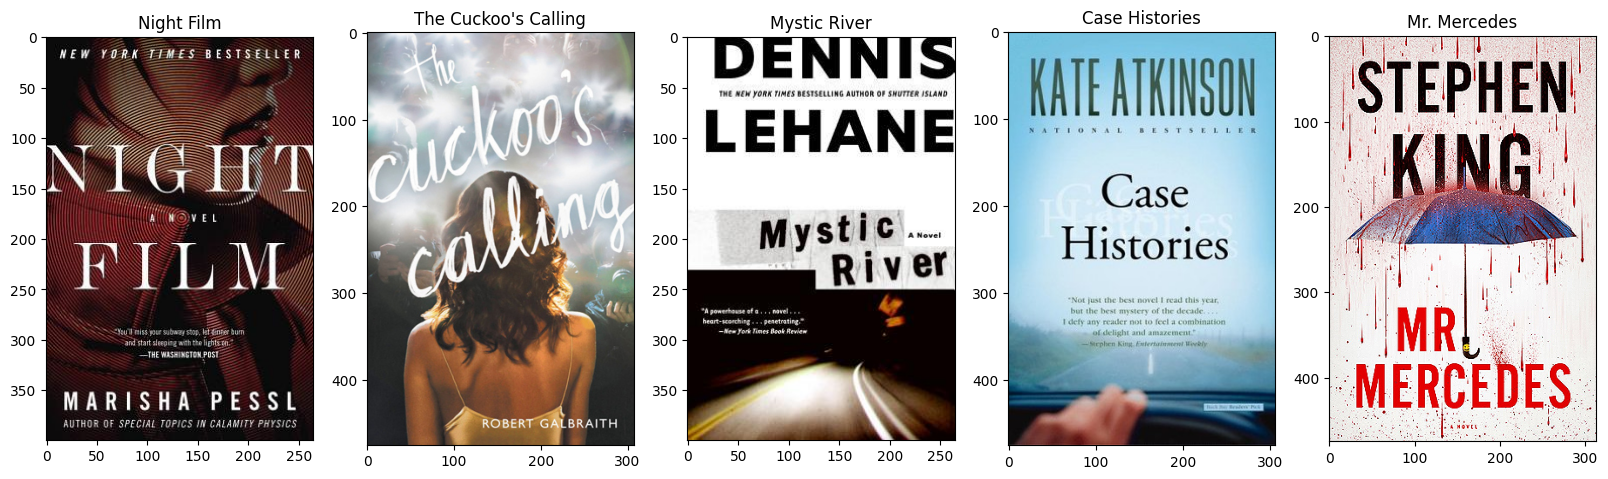

In [21]:
recommendations("The Murder of Roger Ackroyd")

# 12. 문서 임베딩 : 워드 임베딩의 평균(Average Word Embedding)
임베딩이 잘 된 상황에서는 단어 벡터들의 평균만으로 텍스트 분류를 수행할 수 있다.   

영화 사이트 IMDB 영화 리뷰 데이터
- 리뷰 텍스트 : 리뷰가 긍정인 경우 1을, 부정인 경우 0으로 레이블링
- 훈련 데이터와 테스트 데이터 각각 25,000개
- 정수 인코딩까지의 전처리가 진행되어져 있으므로, 단어 집합을 만들고, 각 단어를 정수로 인코딩하는 과정을 할 필요가 없다.

## 12.1 데이터 로드와 전처리

In [22]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [23]:
vocab_size = 20000

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)
   # num_words : 등장 빈도 순위로 몇 번째에 해당하는 단어까지를 사용할 것인지

print('훈련용 리뷰 개수 :',len(X_train))
print('테스트용 리뷰 개수 :',len(X_test))

17464789/17464789 [==============================] - 0s 0us/step
훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000


In [25]:
print('훈련 데이터의 첫번째 샘플 :',X_train[0])
print('훈련 데이터의 첫번째 샘플의 레이블 :',y_train[0])  # 1 : 긍정리뷰

훈련 데이터의 첫번째 샘플 : [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
훈련 데이터의 첫번째 샘플의 레이블 : 1


In [26]:
# 각 리뷰의 평균 길이 계산
print('훈련용 리뷰의 평규 길이: {}'.format(np.mean(list(map(len, X_train)), dtype=int)))
print('테스트용 리뷰의 평균 길이: {}'.format(np.mean(list(map(len, X_test)), dtype=int)))

훈련용 리뷰의 평규 길이: 238
테스트용 리뷰의 평균 길이: 230


In [27]:
# 평균보다는 큰 수치인 400으로 패딩
max_len = 400

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
print('X_train의 크기(shape) :', X_train.shape)
print('X_test의 크기(shape) :', X_test.shape)

X_train의 크기(shape) : (25000, 400)
X_test의 크기(shape) : (25000, 400)


## 12.2 모델 설계하기
- GlobalAveragePooling1D()은 입력으로 들어오는 모든 벡터들의 평균을 구하는 역할
- mbedding() 다음에 GlobalAveragePooling1D()을 추가하면 해당 문장의 모든 단어 벡터들의 평균 벡터를 구한다.

In [28]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 64

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))

# 모든 단어 벡터의 평균을 구한다.
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('embedding_average_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, batch_size=32, epochs=10, callbacks=[es, mc], validation_split=0.2)

Epoch 1/10
624/625 [============================>.] - ETA: 0s - loss: 0.6264 - acc: 0.7370
Epoch 1: val_acc improved from -inf to 0.81240, saving model to embedding_average_model.h5
625/625 [==============================] - 15s 24ms/step - loss: 0.6264 - acc: 0.7369 - val_loss: 0.5190 - val_acc: 0.8124
Epoch 2/10
624/625 [============================>.] - ETA: 0s - loss: 0.4273 - acc: 0.8564
Epoch 2: val_acc improved from 0.81240 to 0.86020, saving model to embedding_average_model.h5
625/625 [==============================] - 17s 28ms/step - loss: 0.4272 - acc: 0.8565 - val_loss: 0.3816 - val_acc: 0.8602
Epoch 3/10
624/625 [============================>.] - ETA: 0s - loss: 0.3174 - acc: 0.8930
Epoch 3: val_acc improved from 0.86020 to 0.87980, saving model to embedding_average_model.h5
625/625 [==============================] - 16s 25ms/step - loss: 0.3174 - acc: 0.8930 - val_loss: 0.3225 - val_acc: 0.8798
Epoch 4/10
624/625 [============================>.] - ETA: 0s - loss: 0.2606 - 

In [29]:
# 학습이 끝난 후 테스트 데이터에 대해 평가
loaded_model = load_model('embedding_average_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

782/782 [==============================] - 2s 3ms/step - loss: 0.2857 - acc: 0.8878

 테스트 정확도: 0.8878


> 별 다른 신경망을 추가하지 않고 단어 벡터의 평균만으로도 88.78%라는 준수한 정확도를 얻어내는 것을 확인할 수 있다.

# 13. Doc2Vec으로 공시 사업보고서 유사도 계산하기
**Doc2Vec** : Word2Vec을 변형하여 문서의 임베딩을 얻을 수 있도록 한 알고리즘   
gensim을 통해 쉽게 사용 가능

전자공시시스템(Dart)에 올라와있는 각 회사의 사업보고서를 Doc2Vec을 통해서 학습시키고, 특정 회사와 사업 보고서가 유사한 회사들을 찾아보자.

해당 실습은 형태소 분석기 Mecab의 원활한 설치를 위해서 구글의 Colab에서 진행하는 게 좋다... -> pass!! 한 번 읽어보고 넘어감.

# 14. 실전! 한국어 위키피디아로 Word2Vec 학습하기
해당 실습 또한 형태소 분석기 Mecab의 원활한 설치를 위해서 구글의 Colab에서 진행하는 게 좋다... -> pass!! 한 번 읽어보고 넘어감.ㅠㅜㅠㅜ